In [65]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from astroML.datasets import sdss_corrected_spectra
import scipy.sparse as sps
from scipy.sparse.linalg import eigs, eigsh
from sklearn.neighbors import kneighbors_graph

In [3]:
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
rawspec = sdss_corrected_spectra.reconstruct_spectra(data)
lam = sdss_corrected_spectra.compute_wavelengths(data)

In [13]:
print(rawspec.shape)
print(lam.shape)

(4000, 1000)
(1000,)


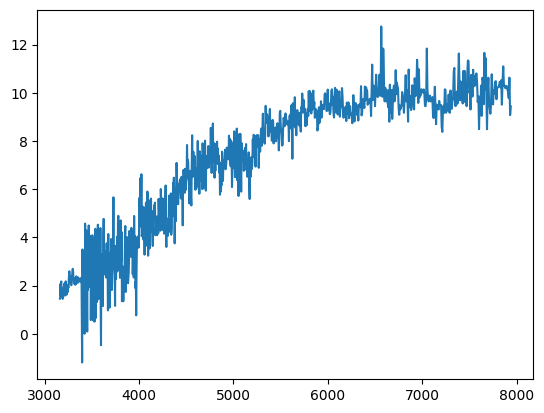

In [12]:
plt.plot(lam, rawspec[4])

In [105]:
# ----------------------------
# Laplacian Eigenmaps (Belkin–Niyogi style)
# ----------------------------
k = 400

# Sparse kNN distance graph (only edges), exclude self-neighbor
G = kneighbors_graph(rawspec, n_neighbors=k, mode="distance", include_self=False)

# Choose bandwidth s ~ median kNN distance (robust)
s = np.median(G.data)

# Heat kernel weights on edges
G.data = np.exp(-(G.data**2) / (2 * s**2))

# Symmetrize W (undirected graph)
W = 0.5 * (G + G.T)

# Degree and Laplacian (sparse)
d = np.asarray(W.sum(axis=1) + 1e-8).ravel()
D = sps.diags(d)
L = D - W

# Generalized eigenproblem: (D - W) v = λ D v
# Compute smallest eigenpairs: need 1 extra to drop the trivial eigenvector
vals, vecs = eigsh(L, M=D, which="SM")  # SM = smallest magnitude
idx = np.argsort(vals)
vals, vecs = vals[idx], vecs[:, idx]

X_le = vecs[:, 1:3]  # drop trivial constant eigenvector

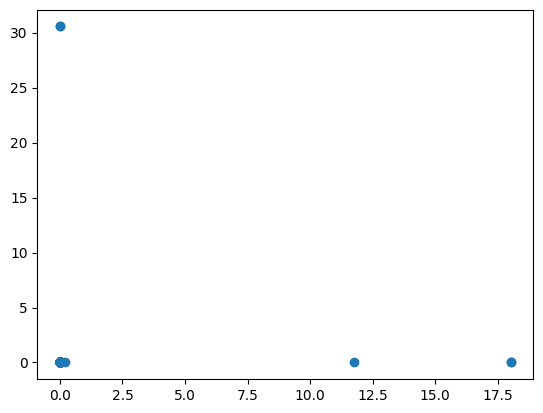

In [106]:
X_le = vecs[:, 1:3]
plt.scatter(X_le[:, 0], X_le[:, 1])

In [72]:
from sklearn.manifold import SpectralEmbedding
embedding = SpectralEmbedding(n_components=12,
                            affinity='precomputed',
                            
                            n_neighbors=400)
sigma = 4
nbrs = kneighbors_graph(rawspec, n_neighbors=400, mode='distance', include_self=False)
nbrs.data = np.exp((- np.power(nbrs.data, 2) / (2 * (sigma ** 2))))

X_new = embedding.fit_transform(nbrs)
plt.scatter(X_new[:, 0], X_new[:, 1])

KeyboardInterrupt: 